# NN on an Imbalance Dataset

Usually when a dataset is imbalanced there will need to some preprocessing done on the data in order to address the overfitting. However, does NN solve this? Let's find out.

In the notebook below we will train an CNN on the MNist dataset against a single number (i.e. change to binary). In each subsequent trial we will decrease the positive sample by 10% until the number of positive samples only make up ~0.01% of the total dataset. We will start at 10% (since each digit makes up 10% of the dataset). We will choose "0" as the target variable, totally arbitrarily.

## Initial Setup

In [10]:
import time
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./.data/', one_hot=True)

Extracting ./.data/train-images-idx3-ubyte.gz
Extracting ./.data/train-labels-idx1-ubyte.gz
Extracting ./.data/t10k-images-idx3-ubyte.gz
Extracting ./.data/t10k-labels-idx1-ubyte.gz


In [19]:
X_train = mnist.train.images
X_test = mnist.test.images
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')/255
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')/255

Since Keras's labels already come one-hot encoded, we have to do some manipulation to get this back to binary. Again, we choose 0 to be positive and all else to be negative.

In [53]:
y_actual = pd.DataFrame(mnist.train.labels).idxmax(1).values # this gets the actual integer values
print y_actual[:5] # for example

y_train = [1 if y==0 else 0 for y in y_actual] # this changes that previous array to binary
print y_train[:5] # for example

# do the same with test dataset
y_actual = pd.DataFrame(mnist.test.labels).idxmax(1).values
y_test = [1 if y==0 else 0 for y in y_actual]

[7 3 4 6 1]
[0, 0, 0, 0, 0]


## Define network

In [21]:
model = Sequential()
model.add(Convolution2D(32, 5, 5, activation='relu', input_shape=(1,28,28), dim_ordering='th'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(64, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", data_format="channels_first", input_shape=(1, 28, 28...)`
  from ipykernel import kernelapp as app
/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu")`


## Train

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy']) # may want to change this later, but this is the default so let's test this out

In [23]:
t0 = time.time()
model.fit(X_train, y_train,
          batch_size=50,
          nb_epoch=10
         )
print "training time = {}".format(time.time() - t0)

/usr/local/lib64/python2.7/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
55000/55000 [==============================] - 19s - loss: 0.2376 - acc: 0.9258       

### Evaluate

In [41]:
from sklearn.metrics import precision_recall_curve
%matplotlib inline

y_pred = model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

df_pr = pd.DataFrame({'recall':recall, 'precision':precision})

df_pr.plot.scatter('recall','precision')

Looks like the classifier's doing fine so far. Let's take the positives down a notch and try again.

## 1% Setup

First we have to downsample both the X_train and associated y_train. We don't have to touch the X_test or y_test since we're testing the training capability of NNs. Plus this lets us test on the same dataset.

In [60]:
from numpy.random import uniform

In [64]:
d10 = uniform(0, 1, len(y_train)) # create a list of d10

In [69]:
y_train_1 = [] # 1%
for i in range(len(y_train)):
    if y_train[i]==0:
        y_train_1.append(y_train[i])
    elif y_train[i]==1 and d10[i]<0.1:
        y_train_1.append(y_train[i])

In [79]:
print "Length of new y array = "+str(len(y_train_1))
print pd.Series(y_train).value_counts()
print pd.Series(y_train_1).value_counts()

Length of new y array = 50070
0    49556
1     5444
dtype: int64
0    49556
1      514
dtype: int64


Looks like only 10% of the positives remain while all the negatives remain. Great! Let's apply this to the X_train now.

In [74]:
X_train_1 = [] # 1%
for i in range(len(X_train)):
    if y_train[i]==0:
        X_train_1.append(X_train[i])
    elif y_train[i]==1 and d10[i]<0.1:
        X_train_1.append(X_train[i])

In [75]:
len(X_train_1)

50070

Length of new X array checks out.

### Train

In [80]:
t0 = time.time()
model.fit(X_train, y_train,
          batch_size=50,
          nb_epoch=10
         )
print "training time = {}".format(time.time() - t0)

Epoch 1/10
55000/55000 [==============================] - 16s - loss: 0.0094 - acc: 0.9969     

### Evaluate

 9568/10000 [===========================>..] - ETA: 0s

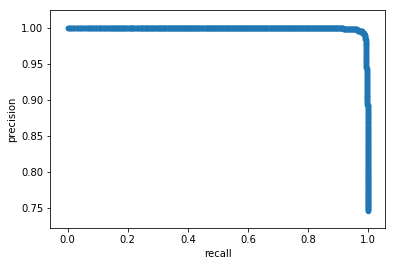

In [81]:
from sklearn.metrics import precision_recall_curve
%matplotlib inline

y_pred = model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

df_pr = pd.DataFrame({'recall':recall, 'precision':precision})

df_pr.plot.scatter('recall','precision')

Still looks great when positives only make up 1% of the sample. Let's keep going!

## 0.1% Setup

We'll be using the same code as above, except this time we'll take even less of the positive dataset.

In [82]:
d10 = uniform(0, 1, len(y_train)) # create a list of d10

In [83]:
y_train_1 = [] # 1%
for i in range(len(y_train)):
    if y_train[i]==0:
        y_train_1.append(y_train[i])
    elif y_train[i]==1 and d10[i]<0.01: # this value was brought even lower
        y_train_1.append(y_train[i])

In [84]:
print "Length of new y array = "+str(len(y_train_1))
print pd.Series(y_train).value_counts()
print pd.Series(y_train_1).value_counts()

Length of new y array = 49608
0    49556
1     5444
dtype: int64
0    49556
1       52
dtype: int64


Looks like only 1% of the positives remain while all the negatives remain. Great! Let's apply this to the X_train now. Not doing too great from a sample size standpoint :\ but maybe it'll still learn.

In [87]:
X_train_1 = [] # 1%
for i in range(len(X_train)):
    if y_train[i]==0:
        X_train_1.append(X_train[i])
    elif y_train[i]==1 and d10[i]<0.01:
        X_train_1.append(X_train[i])

In [88]:
len(X_train_1)

49608

Length of new X array checks out.

### Train

In [89]:
t0 = time.time()
model.fit(X_train, y_train,
          batch_size=50,
          nb_epoch=10
         )
print "training time = {}".format(time.time() - t0)

Epoch 1/10
55000/55000 [==============================] - 16s - loss: 0.0056 - acc: 0.9981         

### Evaluate

 9888/10000 [============================>.] - ETA: 0s

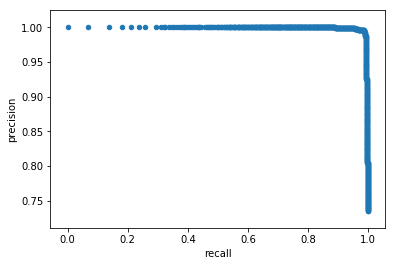

In [90]:
from sklearn.metrics import precision_recall_curve
%matplotlib inline

y_pred = model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

df_pr = pd.DataFrame({'recall':recall, 'precision':precision})

df_pr.plot.scatter('recall','precision')

Still great. Looks like undersampling isn't an issue?